In [ ]:
import SimpleITK as sitk

in_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP3\1720903_TP3.nii"
out_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP3\1720903_TP3_shifted.nii"

img = sitk.ReadImage(in_path)
img_float = sitk.Cast(img, sitk.sitkFloat32)

img_corrected = img_float - 1024.0

sitk.WriteImage(img_corrected, out_path)

print("Saved:", out_path)


Saved: Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP3\1720903_TP3_shifted.nii


In [2]:
#mirror whole ct
import SimpleITK as sitk

img = sitk.ReadImage(r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_shifted.nii")

flipped_array = sitk.GetArrayFromImage(img)[:, :, ::-1]  
img_flipped = sitk.GetImageFromArray(flipped_array)
img_flipped.CopyInformation(img) 

sitk.WriteImage(img_flipped, r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_mirrored.nii")
print("saved")


saved


In [3]:
#mirror mandible
import SimpleITK as sitk

img = sitk.ReadImage(r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz")

flipped_array = sitk.GetArrayFromImage(img)[:, :, ::-1]  
img_flipped = sitk.GetImageFromArray(flipped_array)
img_flipped.CopyInformation(img) 

sitk.WriteImage(img_flipped, r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_mirrored.nii.gz")
print("saved")


saved


In [ ]:
#overlay mirror and original CTs and mandibles
%matplotlib inline

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

ct1_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_shifted.nii"
ct2_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_mirrored.nii"

mand1_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz"
mand2_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_mirrored.nii.gz"

ct1_img = nib.load(ct1_path)
ct2_img = nib.load(ct2_path)

ct1 = ct1_img.get_fdata()
ct2 = ct2_img.get_fdata()

ct1 = (ct1 - np.min(ct1)) / (np.max(ct1) - np.min(ct1))
ct2 = (ct2 - np.min(ct2)) / (np.max(ct2) - np.min(ct2))

spacing = ct1_img.header.get_zooms()

mand1 = nib.load(mand1_path).get_fdata() > 0.5
mand2 = nib.load(mand2_path).get_fdata() > 0.5

color_mand1 = (1, 1, 0, 0.45)   # original mandible = yellow
color_mand2 = (0, 1, 1, 0.45)   # mirrored mandible = cyan

# Bone colormap for CT2
overlay_cmap = plt.cm.bone
overlay_cmap.set_under(alpha=0)

def show_slice(slice_index, plane, alpha=0.35):

    plt.figure(figsize=(6, 6))

    if plane == 'Axial':
        img1 = np.rot90(ct1[:, :, slice_index])
        img2 = np.rot90(ct2[:, :, slice_index])

        m1 = np.rot90(mand1[:, :, slice_index])
        m2 = np.rot90(mand2[:, :, slice_index])

        aspect = spacing[1] / spacing[0]

    elif plane == 'Coronal':
        img1 = np.flipud(np.rot90(ct1[:, slice_index, :]))
        img2 = np.flipud(np.rot90(ct2[:, slice_index, :]))

        m1 = np.flipud(np.rot90(mand1[:, slice_index, :]))
        m2 = np.flipud(np.rot90(mand2[:, slice_index, :]))

        aspect = spacing[2] / spacing[0]

    elif plane == 'Sagittal':
        img1 = np.flipud(np.rot90(ct1[slice_index, :, :]))
        img2 = np.flipud(np.rot90(ct2[slice_index, :, :]))

        m1 = np.flipud(np.rot90(mand1[slice_index, :, :]))
        m2 = np.flipud(np.rot90(mand2[slice_index, :, :]))

        aspect = spacing[2] / spacing[1]


    plt.imshow(img1, cmap='gray', origin='lower', aspect=aspect)

    ct2_rgba = overlay_cmap(img2)
    ct2_rgba[..., 3] = alpha  
    plt.imshow(ct2_rgba, origin='lower', aspect=aspect)

    overlay1 = np.zeros((*m1.shape, 4))
    overlay1[m1] = (*color_mand1[:3], alpha)
    plt.imshow(overlay1, origin='lower', aspect=aspect)

    overlay2 = np.zeros((*m2.shape, 4))
    overlay2[m2] = (*color_mand2[:3], alpha)
    plt.imshow(overlay2, origin='lower', aspect=aspect)

    plt.title(f"{plane} slice {slice_index}")
    plt.axis("off")

    legend_handles = [
        plt.Line2D([0], [0], color=color_mand1[:3], lw=4, label="Mandible 1"),
        plt.Line2D([0], [0], color=color_mand2[:3], lw=4, label="Mandible 2"),
        plt.Line2D([0], [0], color="gray", lw=4, label="CT1 (base)"),
        plt.Line2D([0], [0], color="black", lw=4, label="CT2 (bone colormap)"),
    ]
    plt.legend(handles=legend_handles, loc='upper right', fontsize=8, frameon=False, labelcolor = "white")

    clear_output(wait=True)
    display(plt.gcf())
    plt.close()


plane_dropdown = widgets.Dropdown(
    options=['Axial', 'Coronal', 'Sagittal'],
    value='Axial',
    description='Plane:'
)

slice_slider = widgets.IntSlider(
    value=ct1.shape[2] // 2,
    min=0,
    max=ct1.shape[2] - 1,
    step=1,
    description='Slice:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

alpha_slider = widgets.FloatSlider(
    value=0.35,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Opacity:',
    continuous_update=True,
    layout=widgets.Layout(width='60%')
)


def update_slider_range(*args):
    plane = plane_dropdown.value
    if plane == 'Axial':
        slice_slider.max = ct1.shape[2] - 1
        slice_slider.value = ct1.shape[2] // 2
    elif plane == 'Coronal':
        slice_slider.max = ct1.shape[1] - 1
        slice_slider.value = ct1.shape[1] // 2
    elif plane == 'Sagittal':
        slice_slider.max = ct1.shape[0] - 1
        slice_slider.value = ct1.shape[0] // 2

plane_dropdown.observe(update_slider_range, names='value')
update_slider_range()

widgets.interact(
    show_slice,
    slice_index=slice_slider,
    plane=plane_dropdown,
    alpha=alpha_slider
)


interactive(children=(IntSlider(value=89, description='Slice:', layout=Layout(width='80%'), max=178), Dropdown…

<function __main__.show_slice(slice_index, plane, alpha=0.35)>

In [ ]:
#perform registration on the CT
import SimpleITK as sitk

fixed = sitk.ReadImage(r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_shifted.nii")   
moving = sitk.ReadImage(r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_mirrored.nii")   

initial_tx = sitk.CenteredTransformInitializer(
    fixed,
    moving,
    sitk.VersorRigid3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY
)

reg = sitk.ImageRegistrationMethod()

reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
reg.SetMetricSamplingPercentage(0.2, sitk.sitkWallClock)
reg.SetMetricSamplingStrategy(reg.RANDOM)

reg.SetInterpolator(sitk.sitkLinear)

reg.SetOptimizerAsRegularStepGradientDescent(
    learningRate=2.0,
    minStep=1e-4,
    numberOfIterations=200,
    gradientMagnitudeTolerance=1e-6
)

# prevents big rotations that cause the optimizer to flip
reg.SetOptimizerScalesFromPhysicalShift()

reg.SetInitialTransform(initial_tx, inPlace=False)

final_tx = reg.Execute(fixed, moving)

sitk.WriteTransform(final_tx, r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\rigid_mirror_to_original.tfm")
print("Saved registration transform")

resampler = sitk.ResampleImageFilter()

resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetTransform(final_tx)

registered_mirror_CT = resampler.Execute(moving)

sitk.WriteImage(registered_mirror_CT, r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mirror_registered_ct.nii.gz")
print("Saved registered CT")

Saved registration transform
Saved registered CT


In [ ]:
#perform same registration on the mandible
mand = sitk.ReadImage(r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_mirrored.nii.gz")

resamp_seg = sitk.ResampleImageFilter()
resamp_seg.SetReferenceImage(fixed)
resamp_seg.SetInterpolator(sitk.sitkNearestNeighbor)
resamp_seg.SetTransform(final_tx)

registered_mand = resamp_seg.Execute(mand)
sitk.WriteImage(registered_mand, r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_registered_mirrored.nii.gz")

print("Saved registered mandible")


Saved registered mandible


In [ ]:
#overlay registered CTs and mandibles
%matplotlib inline

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

ct1_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_shifted.nii"
ct2_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mirror_registered_ct.nii.gz"

mand1_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz"
mand2_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_registered_mirrored.nii.gz"

ct1_img = nib.load(ct1_path)
ct2_img = nib.load(ct2_path)

ct1 = ct1_img.get_fdata()
ct2 = ct2_img.get_fdata()

# Normalize both CTs to 0–1 for display consistency
ct1 = (ct1 - np.min(ct1)) / (np.max(ct1) - np.min(ct1))
ct2 = (ct2 - np.min(ct2)) / (np.max(ct2) - np.min(ct2))

spacing = ct1_img.header.get_zooms()

mand1 = nib.load(mand1_path).get_fdata() > 0.5
mand2 = nib.load(mand2_path).get_fdata() > 0.5

color_mand1 = (1, 1, 0, 0.45)   # original mandible = yellow
color_mand2 = (0, 1, 1, 0.45)   # mirrored mandible = cyan

overlay_cmap = plt.cm.bone
overlay_cmap.set_under(alpha=0)

def show_slice(slice_index, plane, alpha=0.35):

    plt.figure(figsize=(6, 6))

    if plane == 'Axial':
        img1 = np.rot90(ct1[:, :, slice_index])
        img2 = np.rot90(ct2[:, :, slice_index])

        m1 = np.rot90(mand1[:, :, slice_index])
        m2 = np.rot90(mand2[:, :, slice_index])

        aspect = spacing[1] / spacing[0]

    elif plane == 'Coronal':
        img1 = np.flipud(np.rot90(ct1[:, slice_index, :]))
        img2 = np.flipud(np.rot90(ct2[:, slice_index, :]))

        m1 = np.flipud(np.rot90(mand1[:, slice_index, :]))
        m2 = np.flipud(np.rot90(mand2[:, slice_index, :]))

        aspect = spacing[2] / spacing[0]

    elif plane == 'Sagittal':
        img1 = np.flipud(np.rot90(ct1[slice_index, :, :]))
        img2 = np.flipud(np.rot90(ct2[slice_index, :, :]))

        m1 = np.flipud(np.rot90(mand1[slice_index, :, :]))
        m2 = np.flipud(np.rot90(mand2[slice_index, :, :]))

        aspect = spacing[2] / spacing[1]


    plt.imshow(img1, cmap='gray', origin='lower', aspect=aspect)

    ct2_rgba = overlay_cmap(img2)
    ct2_rgba[..., 3] = alpha 
    plt.imshow(ct2_rgba, origin='lower', aspect=aspect)

    overlay1 = np.zeros((*m1.shape, 4))
    overlay1[m1] = (*color_mand1[:3], alpha)
    plt.imshow(overlay1, origin='lower', aspect=aspect)

    overlay2 = np.zeros((*m2.shape, 4))
    overlay2[m2] = (*color_mand2[:3], alpha)
    plt.imshow(overlay2, origin='lower', aspect=aspect)

    plt.title(f"{plane} slice {slice_index}")
    plt.axis("off")

    legend_handles = [
        plt.Line2D([0], [0], color=color_mand1[:3], lw=4, label="Mandible 1"),
        plt.Line2D([0], [0], color=color_mand2[:3], lw=4, label="Mandible 2"),
        plt.Line2D([0], [0], color="gray", lw=4, label="CT1 (base)"),
        plt.Line2D([0], [0], color="black", lw=4, label="CT2 (bone colormap)"),
    ]
    plt.legend(handles=legend_handles, loc='upper right', fontsize=8, frameon=False, labelcolor = "white")

    clear_output(wait=True)
    display(plt.gcf())
    plt.close()


plane_dropdown = widgets.Dropdown(
    options=['Axial', 'Coronal', 'Sagittal'],
    value='Axial',
    description='Plane:'
)

slice_slider = widgets.IntSlider(
    value=ct1.shape[2] // 2,
    min=0,
    max=ct1.shape[2] - 1,
    step=1,
    description='Slice:',
    continuous_update=True,
    layout=widgets.Layout(width='80%')
)

alpha_slider = widgets.FloatSlider(
    value=0.35,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Opacity:',
    continuous_update=True,
    layout=widgets.Layout(width='60%')
)

def update_slider_range(*args):
    plane = plane_dropdown.value
    if plane == 'Axial':
        slice_slider.max = ct1.shape[2] - 1
        slice_slider.value = ct1.shape[2] // 2
    elif plane == 'Coronal':
        slice_slider.max = ct1.shape[1] - 1
        slice_slider.value = ct1.shape[1] // 2
    elif plane == 'Sagittal':
        slice_slider.max = ct1.shape[0] - 1
        slice_slider.value = ct1.shape[0] // 2

plane_dropdown.observe(update_slider_range, names='value')
update_slider_range()

widgets.interact(
    show_slice,
    slice_index=slice_slider,
    plane=plane_dropdown,
    alpha=alpha_slider
)


interactive(children=(IntSlider(value=89, description='Slice:', layout=Layout(width='80%'), max=178), Dropdown…

<function __main__.show_slice(slice_index, plane, alpha=0.35)>

In [ ]:
#combine mandible segmentations
import SimpleITK as sitk
import numpy as np
import os

orig_mandible_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz"
mirr_mandible_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_registered_mirrored.nii.gz"

output_combined = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\combined_mandible_mask.nii.gz"

orig = sitk.ReadImage(orig_mandible_path)
mirr = sitk.ReadImage(mirr_mandible_path)

orig_np = sitk.GetArrayFromImage(orig)
mirr_np = sitk.GetArrayFromImage(mirr)

print("Original mandible loaded:", orig.GetSize())
print("Mirrored mandible loaded:", mirr.GetSize())

combined_np = np.logical_or(orig_np > 0, mirr_np > 0).astype(np.uint8)

combined = sitk.GetImageFromArray(combined_np)
combined.CopyInformation(orig)

sitk.WriteImage(combined, output_combined)

print("Combined mask saved to:", output_combined)

Original mandible loaded: (512, 512, 179)
Mirrored mandible loaded: (512, 512, 179)
Combined mask saved to: Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP1\combined_mandible_mask.nii.gz


In [ ]:
#create and save midline
import SimpleITK as sitk
import numpy as np
import os

combined_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\combined_mandible_mask.nii.gz"
output_midline_file = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\midline_x.txt"

combined = sitk.ReadImage(combined_path)
comb_np = sitk.GetArrayFromImage(combined)

coords = np.column_stack(np.nonzero(comb_np))  

print("Combined mask loaded.")
print("Nonzero voxels found:", len(coords))

physical_x = []
for idx in coords:
    pt = combined.TransformIndexToPhysicalPoint((int(idx[2]), int(idx[1]), int(idx[0])))
    physical_x.append(pt[0])

physical_x = np.array(physical_x)

leftmost = physical_x.min()
rightmost = physical_x.max()
mid_x = (leftmost + rightmost) / 2.0

with open(output_midline_file, "w") as f:
    f.write(str(mid_x))

print("Leftmost X:", leftmost)
print("Rightmost X:", rightmost)
print("MIDLINE X:", mid_x)
print("Saved midline to:", output_midline_file)


Combined mask loaded.
Nonzero voxels found: 88084
Leftmost X: -63.778846740722656
Rightmost X: 53.220054626464844
MIDLINE X: -5.279396057128906
Saved midline to: Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP1\midline_x.txt


Midline X = -5.279396057128906


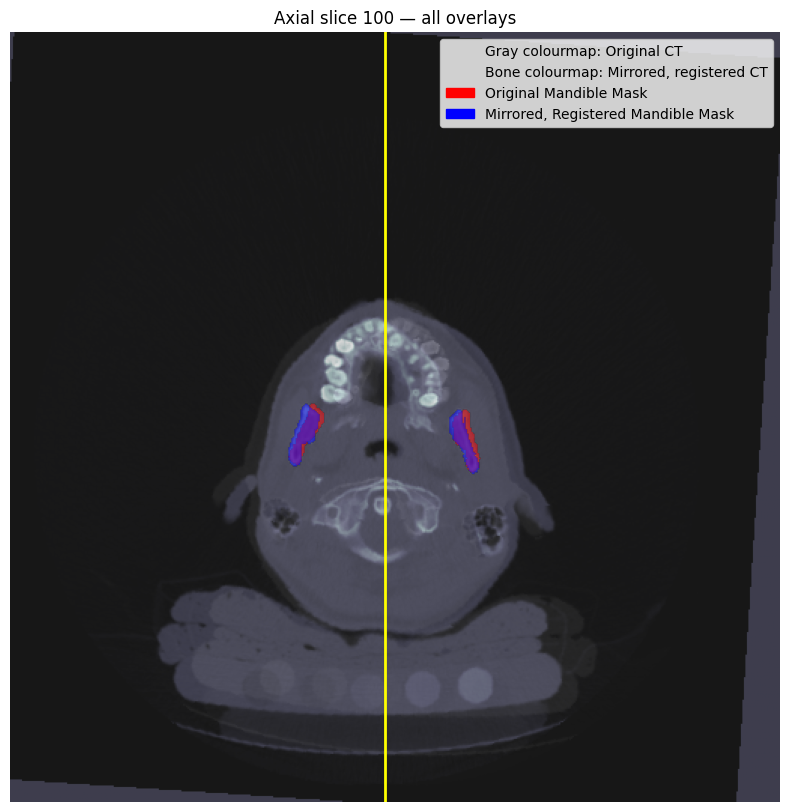

In [ ]:
#visualise midline
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

orig_ct_path   = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\1720903_TP2_shifted.nii"
mirr_ct_path   = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mirror_registered_ct.nii.gz"

orig_mand_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz"
mirr_mand_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_registered_mirrored.nii.gz"

midline_file = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\midline_x.txt"

orig_ct   = sitk.ReadImage(orig_ct_path)
mirr_ct   = sitk.ReadImage(mirr_ct_path)
orig_mand = sitk.ReadImage(orig_mand_path)
mirr_mand = sitk.ReadImage(mirr_mand_path)

with open(midline_file, "r") as f:
    mid_x = float(f.read())

print("Midline X =", mid_x)

orig_np = sitk.GetArrayFromImage(orig_ct)
mirr_np = sitk.GetArrayFromImage(mirr_ct)
orig_mand_np = sitk.GetArrayFromImage(orig_mand)
mirr_mand_np = sitk.GetArrayFromImage(mirr_mand)

plane = "Axial"   
slice_index = 100  

def get_slice(img_np, m1_np, m2_np, plane, idx):
    if plane == "Axial":
        return img_np[idx], m1_np[idx], m2_np[idx]
    elif plane == "Coronal":
        return img_np[:, idx, :], m1_np[:, idx, :], m2_np[:, idx, :]
    elif plane == "Sagittal":
        return img_np[:, :, idx], m1_np[:, :, idx], m2_np[:, :, idx]
    else:
        raise ValueError("Plane must be axial/coronal/sagittal")

orig_slice, orig_mask_slice, mirr_mask_slice = get_slice(
    orig_np, orig_mand_np, mirr_mand_np, plane, slice_index
)

mirr_slice, _, _ = get_slice(
    mirr_np, orig_mand_np, mirr_mand_np, plane, slice_index
)
def compute_midline_pixel(img, plane, idx):
    size = img.GetSize()

    if plane == "Axial":
        row = size[1] // 2
        xs = [img.TransformIndexToPhysicalPoint((x, row, idx))[0] for x in range(size[0])]
        return np.argmin(np.abs(np.array(xs) - mid_x))

    elif plane == "Coronal":
        z = size[2] // 2
        xs = [img.TransformIndexToPhysicalPoint((x, idx, z))[0] for x in range(size[0])]
        return np.argmin(np.abs(np.array(xs) - mid_x))

    else:
        return None  

mid_col = compute_midline_pixel(orig_ct, plane, slice_index)

solid_red = np.zeros((*orig_mask_slice.shape, 4))
solid_red[..., 0] = 1      # R
solid_red[..., 3] = 0.5    # alpha only where mask > 0
solid_red[orig_mask_slice == 0] = 0

solid_blue = np.zeros((*orig_mask_slice.shape, 4))
solid_blue[..., 2] = 1     # B
solid_blue[..., 3] = 0.5   # alpha
solid_blue[mirr_mask_slice == 0] = 0

plt.figure(figsize=(10,10))

plt.imshow(orig_slice, cmap="gray", alpha=0.7)

plt.imshow(mirr_slice, cmap="bone", alpha=0.7)

plt.imshow(solid_red)

plt.imshow(solid_blue)

if mid_col is not None:
    plt.axvline(mid_col, color='yellow', linewidth=2)

orig_ct_patch = mpatches.Patch(
    facecolor='none', edgecolor='none', linewidth=0,
    label='Gray colourmap: Original CT'
)

mir_ct_patch = mpatches.Patch(
    facecolor='none', edgecolor='none', linewidth=0,
    label='Bone colourmap: Mirrored, registered CT'
)

orig_mand_patch = mpatches.Patch(color='red', label='Original Mandible Mask')
mir_mand_patch = mpatches.Patch(color='blue', label='Mirrored, Registered Mandible Mask')

plt.legend(
    handles=[orig_ct_patch, mir_ct_patch, orig_mand_patch, mir_mand_patch],
    loc='upper right'
)
plt.title(f"{plane} slice {slice_index} — all overlays")
plt.axis("off")
plt.show()


In [ ]:
#split mandible segmentations down the midline
import SimpleITK as sitk
import numpy as np
import os

orig_mandible_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\TotalSegmentator1\mandible.nii.gz"
mirr_mandible_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_registered_mirrored.nii.gz"
midline_file_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\midline_x.txt"

output_dir = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_splits"
os.makedirs(output_dir, exist_ok=True)

orig = sitk.ReadImage(orig_mandible_path)
mirr = sitk.ReadImage(mirr_mandible_path)

with open(midline_file_path, "r") as f:
    mid_x = float(f.read())

print("Midline X loaded:", mid_x)


def split_mask(mask_img, mid_x):
    """Split a mandible mask into left/right halves based on a midline X value in physical space."""
    
    arr = sitk.GetArrayFromImage(mask_img)
    coords = np.column_stack(np.nonzero(arr))  

    left_img  = sitk.Image(mask_img.GetSize(), sitk.sitkUInt8)
    right_img = sitk.Image(mask_img.GetSize(), sitk.sitkUInt8)
    left_img.CopyInformation(mask_img)
    right_img.CopyInformation(mask_img)

    for idx in coords:
       
        itk_idx = (int(idx[2]), int(idx[1]), int(idx[0]))
        phys_pt = mask_img.TransformIndexToPhysicalPoint(itk_idx)
        x = phys_pt[0]

        if x < mid_x:
            left_img.SetPixel(itk_idx, 1)
        else:
            right_img.SetPixel(itk_idx, 1)

    return left_img, right_img


print("Splitting original mandible...")
orig_left, orig_right = split_mask(orig, mid_x)

print("Splitting mirrored mandible...")
mirr_left, mirr_right = split_mask(mirr, mid_x)

sitk.WriteImage(orig_left,  os.path.join(output_dir, "original_left.nii.gz"))
sitk.WriteImage(orig_right, os.path.join(output_dir, "original_right.nii.gz"))
sitk.WriteImage(mirr_left,  os.path.join(output_dir, "mirrored_left.nii.gz"))
sitk.WriteImage(mirr_right, os.path.join(output_dir, "mirrored_right.nii.gz"))

print("\nSaved all splits to:", output_dir)


Midline X loaded: -5.279396057128906
Splitting original mandible...
Splitting mirrored mandible...

Saved all splits to: Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP1\mandible_splits


In [ ]:
#compute asymmetry metrics
import nibabel as nib
import numpy as np
import surface_distance
from surface_distance import metrics

original_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_splits\original_right.nii.gz"
mirrored_registered_path = r"Z:\Angie\SMILE_facialdeformation\StJude_cohort\abby\1720903\TP2\mandible_splits\mirrored_right.nii.gz"

img_original = nib.load(original_path)
img_mirrored_registered = nib.load(mirrored_registered_path)

mask_original = img_original.get_fdata() > 0
mask_mirrored_registered = img_mirrored_registered.get_fdata() > 0

spacing_mm = img_original.header.get_zooms()[:3]
voxel_volume = spacing_mm[0] * spacing_mm[1] * spacing_mm[2]

V_orig = np.sum(mask_original) * voxel_volume
V_mirr = np.sum(mask_mirrored_registered) * voxel_volume
delta_V = abs(V_orig - V_mirr)
AI_raw = delta_V / ((V_orig + V_mirr) / 2)
AI_percent = AI_raw * 100

surface_distances = surface_distance.compute_surface_distances(
    mask_original, mask_mirrored_registered, spacing_mm
)

asd = surface_distance.compute_average_surface_distance(surface_distances)
hausdorff_100 = surface_distance.compute_robust_hausdorff(surface_distances, 100)
hausdorff_95 = surface_distance.compute_robust_hausdorff(surface_distances, 95)

print(f"Original Volume: {V_orig:.1f} mm³ ({V_orig/1000:.2f} cm³)")
print(f"Mirrored Volume: {V_mirr:.1f} mm³ ({V_mirr/1000:.2f} cm³)")
print(f"Volume Difference: {delta_V:.1f} mm³ ({delta_V/1000:.2f} cm³)")
print(f"Asymmetry Index (0-1): {AI_raw:.4f}")
print(f"Asymmetry Index (%): {AI_percent:.2f}%")
#print(f"Voxel spacing (mm): {tuple(float(v) for v in spacing_mm)}")
print(f"Average Surface Distance (GT→Pred, Pred→GT): ({float(asd[0]):.3f}, {float(asd[1]):.3f}) mm")
print(f"Robust Hausdorff (100%): {float(hausdorff_100):.3f} mm")
print(f"Robust Hausdorff (95%): {float(hausdorff_95):.3f} mm")


Original Volume: 39940.2 mm³ (39.94 cm³)
Mirrored Volume: 34281.4 mm³ (34.28 cm³)
Volume Difference: 5658.8 mm³ (5.66 cm³)
Asymmetry Index (0-1): 0.1525
Asymmetry Index (%): 15.25%
Average Surface Distance (GT→Pred, Pred→GT): (3.273, 2.701) mm
Robust Hausdorff (100%): 13.226 mm
Robust Hausdorff (95%): 9.302 mm
